In [1]:
from utils import *

%load_ext autoreload 
%autoreload 2

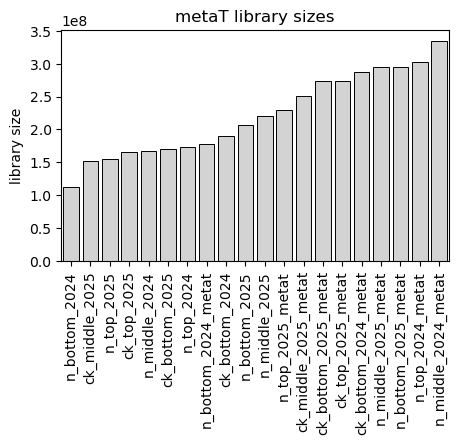

In [2]:
bbduk_df = bbduk_load('../data/bbduk')

fig, ax = plt.subplots(figsize=(5, 3))
figure_df =  bbduk_df[bbduk_df.index.str.contains('ck_|n_')].copy() # Bioreactor samples only.
figure_df = figure_df.reset_index(drop=False) 
figure_df = figure_df.sort_values('library_size')
sns.barplot(figure_df, y='library_size', x='sample_id', color='lightgray', edgecolor='black', lw=0.7) #, hue='library_size', palette='Grays', legend=False)
ax.set_xlabel('')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
ax.set_ylabel('library size')
ax.set_title('metaT library sizes')
plt.show()
# for row in bbduk_df[bbduk_df.index.str.contains('ck_|n_')].itertuples():
#     print(row.Index, row.library_size)

# Library sizes range from around 150,000,000 to 350,000,000. Probably want to be more lenient than not, so select a CPM
# which could correspond to a count of ~5 for 1e8, or (5 / (1e8 / 1e6))

In [3]:
# Want to see if there are any transcriptional changes which are correlated with the decrease in ECEs. 

metat_df = metat_load()

mp_metat_df = metat_df[metat_df.target_name.str.startswith('mp_')].copy()
mp_metat_df = mp_metat_df[~mp_metat_df.target_name.isin(['mp_2'])].copy()
# mp_metat_df = mp_metat_df[mp_metat_df.sample_id != 'n_bottom_2024_metat'].copy()

mp_metat_df = pd.concat([metat_filter(df, threshold=1, min_samples=2, field='read_count') for _, df in mp_metat_df.groupby('target_name', group_keys=True)])

interproscan_df = load_interproscan().rename(columns={'id':'gene_id'})[['target_name', 'gene_id', 'signature_description', 'signature_accession', 'e_value']]
mp_metat_df = mp_metat_df.merge(interproscan_df, on=['target_name', 'gene_id'], how='left')
mp_metat_df = mp_metat_df.sort_values('e_value').drop_duplicates(['target_name', 'sample_id', 'gene_id'])

# Only a handful of genes are expressed (minimum count of 1) across all samples, which will make using ALR difficult. 
# Could it make sense to use different references for each strain? I think so, if the goal is to look for differential
# expression within each organism. However, this will make it difficult to compare across organisms. 

filter_: Keeping 2564 out of 2875 total genes for mp_1.
filter_: Keeping 2311 out of 3055 total genes for mp_3.
filter_: Keeping 2585 out of 3537 total genes for mp_4.
filter_: Keeping 2132 out of 2733 total genes for mp_5.


In [4]:
# RNA polymerase might be a good option because it has multiple subunits which seem like they are in the same operon. 

rnap_gene_ids = dict()
ef2_gene_ids = dict()

interproscan_df = load_interproscan().rename(columns={'id':'gene_id'})[['target_name', 'gene_id', 'signature_description', 'signature_accession', 'e_value']]
interproscan_df = interproscan_df[interproscan_df.target_name.str.startswith('mp_')].copy()

for target_name, df in interproscan_df[interproscan_df.fillna('').signature_description.str.contains('RNA-polymerase')].groupby('target_name'):
    print(f'Num. annotated RNA polymerase genes in {target_name}:', df.gene_id.nunique())
    rnap_gene_ids[target_name] = df.gene_id.unique().tolist()

print()
for target_name, df in interproscan_df[interproscan_df.fillna('').signature_description.str.contains('EF-2')].groupby('target_name'):
    print(f'Num. annotated EF-2 genes in {target_name}:', df.gene_id.nunique())
    ef2_gene_ids[target_name] = df.gene_id.unique().tolist()

def get_ref_mask(df, ref_gene_ids):
    masks = [(df.target_name == target_name) & (df.gene_id.isin(ref_gene_ids[target_name])) for target_name in df.target_name.unique()]
    mask = masks[0]
    for mask_ in masks[1:]:
        mask = mask | mask_
    return mask



Num. annotated RNA polymerase genes in mp_1: 4
Num. annotated RNA polymerase genes in mp_3: 3
Num. annotated RNA polymerase genes in mp_4: 4
Num. annotated RNA polymerase genes in mp_5: 4

Num. annotated EF-2 genes in mp_1: 1
Num. annotated EF-2 genes in mp_3: 1
Num. annotated EF-2 genes in mp_4: 1
Num. annotated EF-2 genes in mp_5: 1


In [5]:
# # For ALR normalization, need "housekeeping" genes whose expression should track baseline transcriptional activity, and 
# # not vary much by condition. Also want to make sure they are (1) annotated in all the Methanoperedens genomes to allow interstrain
# # comparison, (2) are expressed in the majority of samples. Also need to be careful with the ribosomal proteins, as some seem to have multiple copies.

# # ref_signature_descriptions = ['CDC48 family AAA ATPase'] # Seems to be multiple copies of this, also maybe not super stable. 
# ref_signature_descriptions = list()
# ref_signature_descriptions += ['elongation factor EF-2']
# ref_signature_descriptions += ['DNA dependent RNA-polymerase']
# ref_signature_descriptions += ['DNA polymerase II large subunit']
# ref_signature_descriptions += ['DNA gyrase subunit A']
# # ref_signature_descriptions += ['DNA gyrase subunit B']

# # ref_mp_metat_df = mp_metat_df[mp_metat_df.signature_description.isin(ref_signature_descriptions)].copy()
# ref_mp_metat_df = mp_metat_df[mp_metat_df.signature_description.fillna('none').str.contains('|'.join(ref_signature_descriptions))].copy()
# ref_mp_metat_df = ref_mp_metat_df.drop_duplicates(['target_name', 'gene_id', 'sample_id'])

# ref_sample_count_df = ref_mp_metat_df[ref_mp_metat_df.read_count > 0].groupby(['target_name', 'signature_description']).size().reset_index(name='sample_count')
# ref_mp_metat_df = ref_mp_metat_df.merge(ref_sample_count_df, on=['target_name', 'signature_description'])

# ef2_ref_gene_ids = ref_mp_metat_df[ref_mp_metat_df.signature_description == 'elongation factor EF-2'].set_index('target_name').gene_id.to_dict()
# ref_sample_count_df

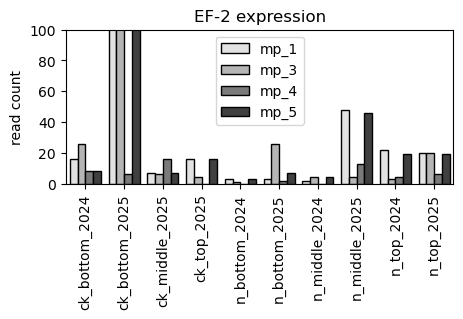

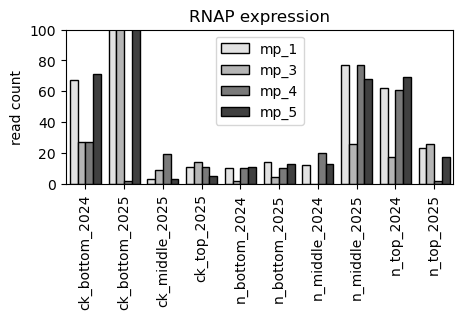

In [6]:
def plot_ref_read_counts(metat_df, ref_gene_ids:dict=None, title=''):
    fig, ax = plt.subplots(figsize=(5, 2))

    figure_df = metat_df.copy()
    figure_df = figure_df[get_ref_mask(figure_df, ref_gene_ids)].copy()
    figure_df = figure_df.groupby(['sample_id', 'target_name']).read_count.sum().reset_index(name='read_count')
    sns.barplot(figure_df, x='sample_id', hue='target_name', palette='Grays', y='read_count', edgecolor='black')
    ax.set_ylabel('read count')
    ax.set_title(title)
    ax.get_legend().set_title('')
    ax.set_xlabel('')
    ax.set_xticks(ax.get_xticks(), [label.get_text().replace('_metat', '') for label in ax.get_xticklabels()], rotation=90)
    ax.set_ylim(ymin=0, ymax=100)
    plt.show()


plot_ref_read_counts(mp_metat_df, ref_gene_ids=ef2_gene_ids, title='EF-2 expression')
plot_ref_read_counts(mp_metat_df, ref_gene_ids=rnap_gene_ids, title='RNAP expression')


In [ ]:
# fig, ax = plt.subplots(figsize=(3, 3))
# # sns.kdeplot(mp_metat_df, x='read_count')
# mp_metat_df.sort_values('read_count'

In [ ]:
ref_gene_ids = {target_name:ef2_gene_ids[target_name] + rnap_gene_ids[target_name] for target_name in ef2_gene_ids}
mp_metat_normalized_df = metat_normalize(mp_metat_df.copy(), ref_gene_ids=ref_gene_ids, method='alr')
mp_metat_normalized_df = metat_normalize(mp_metat_normalized_df, ref_gene_ids=dict(), method='clr')

# fig, ax = plt.subplots()
# sns.scatterplot(mp_metat_normalized_df, x='normalization_factor_alr', y='normalization_factor_clr')
# ax.set_xlim(xmax=20, xmin=0)
# ax.set_ylim(ymin=0, ymax=1)


In [10]:
# Want to look at differences between 2024 and 2025, probably can only compare across depths. 

mp_metat_normalized_df['location'] = [re.search('top|bottom|middle', sample_id).group(0) for sample_id in mp_metat_normalized_df.sample_id]
mp_metat_normalized_df['reactor'] = [re.search('(ck|n)_', sample_id).group(1) for sample_id in mp_metat_normalized_df.sample_id]
mp_metat_normalized_df['year'] = [re.search('2024|2025', sample_id).group(0) for sample_id in mp_metat_normalized_df.sample_id]
mp_metat_normalized_df = mp_metat_normalized_df.sort_values('year')

def get_differential_expression(metat_df:pd.DataFrame):
    diff_df = list()
    diff_cols = [col for col in mp_metat_normalized_df.columns if (re.search('_alr|_clr', col) is not None)] + ['read_count', 'read_count_original', 'coverage']

    for _, df in tqdm(metat_df.groupby(['location', 'reactor', 'gene_id', 'target_name']), 'get_differential_expression'):
        if len(df) != 2:
            # print(f'Skipping a set of paired measurements, DataFrame length is {len(df)}.')
            continue
        row = {col:value for col, value in df.iloc[0].to_dict().items() if (col not in diff_cols)}
        # DataFrame should be sorted by year, so accessing by index should be fine. 
        row.update({f'{col}_2024':value for col, value in df.iloc[0].to_dict().items() if (col in diff_cols)})
        row.update({f'{col}_2025':value for col, value in df.iloc[1].to_dict().items() if (col in diff_cols)})
        diff_df.append(row)

    diff_df = pd.DataFrame(diff_df)
    diff_df = diff_df.drop(columns=['year'])
    diff_df['sample_id'] = [f'{row.reactor}_{row.location}' for row in diff_df.itertuples()]
    return diff_df

mp_metat_normalized_diff_df = get_differential_expression(mp_metat_normalized_df)

# No comparisons where both measurements are zero are valid, basically just comparing pseudocounts. 
mask = (mp_metat_normalized_diff_df.read_count_original_2024 == 0) & (mp_metat_normalized_diff_df.read_count_original_2025 == 0)
print(f'Removing {mask.sum()} paired measurements where both measures are zero.')
mp_metat_normalized_diff_df = mp_metat_normalized_diff_df[~mask].copy()

get_differential_expression: 100%|██████████| 57552/57552 [00:10<00:00, 5641.79it/s] 


Removing 11749 paired measurements where both measures are zero.


<Axes: xlabel='read_count_normalized_alr_diff', ylabel='Density'>

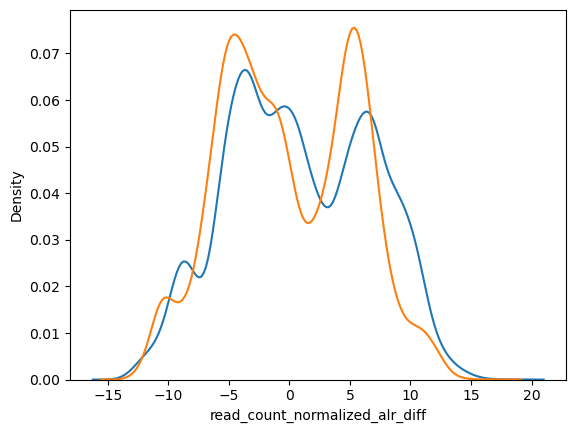

In [13]:
# I think for the differential expression of log-normalized data, it doesn't make sense to think about the ratios (or rather, because
# it is log-transformed, we are already looking at ratios.)


mp_metat_normalized_diff_df['read_count_normalized_clr_diff'] = mp_metat_normalized_diff_df.read_count_normalized_clr_2025 - mp_metat_normalized_diff_df.read_count_normalized_clr_2024
mp_metat_normalized_diff_df['read_count_normalized_alr_diff'] = mp_metat_normalized_diff_df.read_count_normalized_alr_2025 - mp_metat_normalized_diff_df.read_count_normalized_alr_2024

sns.kdeplot(mp_metat_normalized_diff_df, x='read_count_normalized_alr_diff')
sns.kdeplot(mp_metat_normalized_diff_df, x='read_count_normalized_clr_diff')


In [ ]:
# mp_ribosome_proteins_df = pd.read_csv('mp_ribosome_proteins.csv', index_col=0)
# mp_ribosome_proteins_df = mp_ribosome_proteins_df.sort_values('e_value').drop_duplicates(['target_name', 'product'])
# mp_ribosome_proteins_df = mp_ribosome_proteins_df.merge(mp_metat_df[['target_name', 'gene_id', 'read_count', 'sample_id']], on=['gene_id', 'target_name'])
# print('Num. annotated ribosomal proteins:', mp_ribosome_proteins_df['product'].nunique())

# # For ALR, need genes detected in all samples and all strains. 

# figure_df = pd.DataFrame(index=mp_ribosome_proteins_df['product'].unique(), columns=mp_ribosome_proteins_df.target_name.unique())
# for (protein, target_name), df in mp_ribosome_proteins_df[mp_ribosome_proteins_df.read_count > 0].groupby(['product', 'target_name']):
#     figure_df.loc[protein, target_name] = df.sample_id.nunique()

# figure_df['total'] = figure_df.sum(axis=1)
# figure_df.sort_values('total')
# figure_df = figure_df[figure_df.total > 5]
# # mp_ribosome_proteins_df = mp_ribosome_proteins_df[mp_ribosome_proteins_df['product'].isin(figure_df.index)]
# figure_df

# fig, ax = plt.subplots(figsize=(15, 3))

# target_name = 'mp_1'
# figure_df = mp_ribosome_proteins_df.copy()
# figure_df = figure_df[figure_df.read_count < 300].copy()
# # sns.stripplot(figure_df, x='product', y='read_count', hue='target_name', palette='Grays')
# figure_df = figure_df[figure_df.target_name == target_name].copy()
# sns.boxplot(figure_df, x='product', y='read_count', color='lightgray', showfliers=False)
# sns.stripplot(figure_df, x='product', y='read_count', color='gray')
# ax.set_xlabel('')
# ax.set_ylabel('read count')

# ax.set_ylim(ymax=30, ymin=0)# For ALR normalization, need "housekeeping" genes whose expression should track baseline transcriptional activity, and 
# # not vary much by condition. Also want to make sure they are (1) annotated in all the Methanoperedens genomes to allow interstrain
# # comparison, (2) are expressed in the majority of samples. Also need to be careful with the ribosomal proteins, as some seem to have multiple copies.

# # ref_signature_descriptions = ['CDC48 family AAA ATPase'] # Seems to be multiple copies of this, also maybe not super stable. 
# ref_signature_descriptions = list()
# ref_signature_descriptions += ['elongation factor EF-2']
# ref_signature_descriptions += ['DNA dependent RNA-polymerase']
# ref_signature_descriptions += ['DNA polymerase II large subunit']
# ref_signature_descriptions += ['DNA gyrase subunit A']
# # ref_signature_descriptions += ['DNA gyrase subunit B']

# # ref_mp_metat_df = mp_metat_df[mp_metat_df.signature_description.isin(ref_signature_descriptions)].copy()
# ref_mp_metat_df = mp_metat_df[mp_metat_df.signature_description.fillna('none').str.contains('|'.join(ref_signature_descriptions))].copy()
# ref_mp_metat_df = ref_mp_metat_df.drop_duplicates(['target_name', 'gene_id', 'sample_id'])

# ref_sample_count_df = ref_mp_metat_df[ref_mp_metat_df.read_count > 0].groupby(['target_name', 'signature_description']).size().reset_index(name='sample_count')
# ref_mp_metat_df = ref_mp_metat_df.merge(ref_sample_count_df, on=['target_name', 'signature_description'])

# ef2_ref_gene_ids = ref_mp_metat_df[ref_mp_metat_df.signature_description == 'elongation factor EF-2'].set_index('target_name').gene_id.to_dict()
# ref_sample_count_df
# plt.show()

# From https://academic.oup.com/gigascience/article/8/9/giz107/5572529, use the genometric mean of the reference proteins.
# In this case, will need to make sure at least a couple of each of the potential reference proteins is expressed in each 
# Methanoperedens strain in each sample. Perhaps use the geometric mean of the nonzero ones? Though perhaps makes more sense to 
# use all which are detected in each genome. Maybe check correlation between metagenome abundance and the ribosome genes. 

In [ ]:
# Unclear if I specifically need to use CLR-normalized reads for PCA, or if any log-ratio based normalization would work. 

In [ ]:
# Using the CLR-normalized expression normalized within a particular sample to compare across samples could be problematic. 
# Although it avoids problems relating to the inconsistent Methanoperedens abundance, it assumes that most genes in the sample
# are not differentially-expressed, i.e. hover around a "baseline" level of expression. If this is not true (for example, if a whole slew
# of genes is up-regulated), the CLR mean would be skewed, and some genes might show up as differentially-regulated when they are 
# at the same expression level. It may be more robust to pick a subset of housekeeping genes against which to compute the ratios (ALR).
# My current idea is to use the mean expression of a subset of genes in each sample, and use that to center the expression
# of other genes in the sample (looking at the log-ratio). Then we can look for consistent patterns of up- or down- regulation. 

# Not completely sure how useful proportionality will be, especially considering that there doesn't seem to be a ton of overlap
# in the genes which are expressed across samples. From https://www.nature.com/articles/s41598-017-16520-0. 

# I think this approach still won't allow for true cross-sample comparison because of changes in Methanoperedens abundance. 

In [ ]:
# # (1) translation elongation factor EF-1 (subunit alpha, which is the longest)
# ef1a_ref_gene_ids = dict()
# ef1a_ref_gene_ids['mp_1'] = '3_75'
# ef1a_ref_gene_ids['mp_3'] = '34_10'
# ef1a_ref_gene_ids['mp_4'] = '34_10'
# ef1a_ref_gene_ids['mp_5'] = '13_70'

# # (2) elongation factor EF-2
# ef2_ref_gene_ids = dict()
# ef2_ref_gene_ids['mp_1'] = '3_76'
# ef2_ref_gene_ids['mp_3'] = '34_9'
# ef2_ref_gene_ids['mp_4'] = '34_9'
# ef2_ref_gene_ids['mp_5'] = '15_29'

# # (3) ribosomal proteins
# p0_ref_gene_ids = dict()
# p0_ref_gene_ids['mp_1'] = '1_195'
# p0_ref_gene_ids['mp_3'] = '123_7'
# p0_ref_gene_ids['mp_3'] = '123_7'
# p0_ref_gene_ids['mp_5'] = '8_15'

# # (4) RNA polymerase Rpb3, there seems the be more expression of this as opposed to Rpb6.
# rpb3_ref_gene_ids = dict()
# rpb3_ref_gene_ids['mp_1'] = '12_45'
# rpb3_ref_gene_ids['mp_3'] = '42_1'
# rpb3_ref_gene_ids['mp_3'] = '42_1'
# rpb3_ref_gene_ids['mp_5'] = '1_196'